# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded_MPCC_P import VLE_block_rule
from physics.MPCC_P import P_NCP_block_rule, P_Reg_block_rule, P_pf_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=3000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.P_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## MPCC: P-Pspec

In [10]:
model.MPCC = pe.Block(rule = P_Reg_block_rule)

> Importing MPCC_P_Reg Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC.s_L
| MPCC.s_V
| MPCC.epi
--------------------------------------------------
> Adding complementarity constraint, spliting pressure used in VLE



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [11]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [12]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [13]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [14]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [15]:
model.cat.fix(300)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0/2)
model.z['H2'].fix(0.8/(1+0.8)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [16]:
check_DOF(pe,model)

Active Equality Constraints:	 1182
Active Inequality Constraints:	 2
Active Variables:		 1357
Fixed Variables:		 172
DOF:				 3


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [17]:
model.T.setub(300+273.15)

In [18]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.cat,sense=pe.minimize)
# model.obj = pe.Objective(expr = model.T - model.MPCC.pf ,sense=pe.maximize)
model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)

In [19]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'
# opt.options['recalc_y'] = 'yes'
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with

  79 -5.3985097e+02 4.18e+00 2.46e+10  -5.7 6.66e+02    -  8.41e-01 5.72e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -5.4077909e+02 3.52e+00 2.78e+10  -5.7 6.53e+02    -  1.22e-04 2.50e-01h  1
  81 -5.4146725e+02 3.06e+00 2.79e+10  -5.7 6.40e+02    -  1.53e-01 1.90e-01h  1
  82 -5.4282395e+02 2.72e+00 4.37e+10  -5.7 6.29e+02    -  1.00e+00 3.83e-01h  1
  83 -5.4282395e+02 2.72e+00 4.37e+10  -5.7 6.19e+02    -  2.24e-03 1.06e-06h  2
  84 -5.4495351e+02 3.09e+00 1.78e+11  -5.7 6.18e+02    -  6.50e-01 6.16e-01f  1
  85 -5.4495376e+02 3.09e+00 1.78e+11  -5.7 6.35e+02    -  1.00e+00 6.89e-05h  1
  86 -5.4641422e+02 2.76e+00 8.19e+10  -5.7 6.27e+02    -  1.00e+00 4.21e-01f  1
  87 -5.4641422e+02 2.76e+00 8.19e+10  -5.7 6.23e+02    -  9.65e-04 1.06e-06h  2
  88 -5.4851893e+02 3.07e+00 1.69e+11  -5.7 6.20e+02    -  8.69e-01 6.17e-01f  1
  89 -5.4851894e+02 3.07e+00 1.69e+11  -5.7 6.44e+02    -  9.06e-03 2.27e-06h  2
iter    objective    inf_pr 


Number of objective function evaluations             = 250
Number of objective gradient evaluations             = 154
Number of equality constraint evaluations            = 250
Number of inequality constraint evaluations          = 250
Number of equality constraint Jacobian evaluations   = 177
Number of inequality constraint Jacobian evaluations = 177
Number of Lagrangian Hessian evaluations             = 169
Total CPU secs in IPOPT (w/o function evaluations)   =     11.452
Total CPU secs in NLP function evaluations           =      0.501

EXIT: Optimal Solution Found.


In [20]:
model.T.value

573.15

In [21]:
model.MPCC.s_L.value

147.10115156348581

In [22]:
model.VLE_block.P_VLE.value

167.1011504690078

In [23]:
model.L['out'].value

0.0

In [24]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0000			Vapor: 0.4593
------------------------------------------------------------------------------------------------------------
H2         		 0.2828%			 0.7035%
CO         		 0.2377%			 0.5086%
CO2        		46.5716%			55.9864%
H2O        		10.7859%			 8.4733%
C2H4       		 5.6346%			 5.5577%
C3H6       		 5.8014%			 3.1957%
C4H8       		 2.3439%			 1.4195%
C5H10      		 1.6857%			 0.5496%
C6H12      		 1.3145%			 0.2569%
C7H14      		 0.9576%			 0.1201%
C8H16      		 0.6655%			 0.0561%
C9H18      		 0.4470%			 0.0262%
C10H20     		 0.2925%			 0.0123%
C11H22     		 0.1195%			 0.0037%
C12H24     		 0.0754%			 0.0017%
C13H26     		 0.0469%			 0.0008%
C14H28     		 0.0289%			 0.0004%
C15H30     		 0.0176%			 0.0002%
C16H32     		 0.0107%			 0.0001%
C17H34     		 0.0064%			 0.0000%
C18H36     		 0.0038%			 0.0000%
C19H38     		 0.0023%			 0.0000%
C20H40     		 0.0013%			 0.0000%
C1H4       		13.3450%			18.2816%
C2H6       		 3.2223%			 2.9880%
C3H8       		 1.3634%			

# Iterative Solve for Data Analysis

In [25]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [26]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [27]:
catrange = [3000,1000,500,300,100,50,25,10]
Trange = np.linspace(300+273.15,200+273.15,26)

In [28]:
rf_data_master = {}

for c in catrange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.cat ,sense=pe.minimize)

    model.solutions.load_from(results_anchor)
    update_dual(pe,model) 
       
    model.T.fix(300+273.15)
    model.cat.fixed = False
    model.cat.setlb(c)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    update_dual(pe,model)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)
    model.T.fixed = False
    model.cat.fixed = True
    
    
    print('\nWorking on Cat = {} kg'.format(model.cat.value))
    print('-'*108)
    
    rf_data = {}
    rf_data['x'] = {};rf_data['y'] = {};
    rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['P_VLE'] = []; 
    rf_data['s_L'] = [];
    for i in m.COMP_TOTAL:
        rf_data['x'][i] = []
        rf_data['y'][i] = []       

    for t in Trange:
        model.T.setub(t)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        model.T.setub(300+273.15)
        print('Solved\t|T = {:.2f} K\t|V = {:.4f} kmol/s\t|L = {:.4f} kmol/s\t|s_L = {:.4f}\t|P_VLE = {:.1f}'.\
              format(model.T.value,model.V['out'].value,model.L['out'].value,model.MPCC.s_L.value,model.VLE_block.P_VLE.value))
    
        rf_data['T'].append(model.T.value)
        rf_data['Q'].append(model.Q_main.value)
        rf_data['V'].append(model.V['out'].value)
        rf_data['L'].append(model.L['out'].value)
        rf_data['P_VLE'].append(model.VLE_block.P_VLE.value)
        rf_data['s_L'].append(model.MPCC.s_L.value)

        for i in m.COMP_TOTAL:
            rf_data['x'][i].append(model.x[i].value)
            rf_data['y'][i].append(model.y[i].value)
        
    rf_data_master[c] = rf_data


Working on Cat = 3000.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.4565 kmol/s	|L = 0.0000 kmol/s	|s_L = 145.8946	|P_VLE = 165.9
Solved	|T = 569.15 K	|V = 0.4534 kmol/s	|L = 0.0000 kmol/s	|s_L = 140.3887	|P_VLE = 160.4
Solved	|T = 565.15 K	|V = 0.4502 kmol/s	|L = 0.0000 kmol/s	|s_L = 134.1961	|P_VLE = 154.2
Solved	|T = 561.15 K	|V = 0.4468 kmol/s	|L = 0.0000 kmol/s	|s_L = 127.2003	|P_VLE = 147.2
Solved	|T = 557.15 K	|V = 0.4432 kmol/s	|L = 0.0000 kmol/s	|s_L = 119.2571	|P_VLE = 139.3
Solved	|T = 553.15 K	|V = 0.4394 kmol/s	|L = 0.0000 kmol/s	|s_L = 110.1902	|P_VLE = 130.2
Solved	|T = 549.15 K	|V = 0.4353 kmol/s	|L = 0.0000 kmol/s	|s_L = 99.7879	|P_VLE = 119.8
Solved	|T = 545.15 K	|V = 0.4312 kmol/s	|L = 0.0000 kmol/s	|s_L = 87.8077	|P_VLE = 107.8
Solved	|T = 541.15 K	|V = 0.4269 kmol/s	|L = 0.0000 kmol/s	|s_L = 74.0011	|P_VLE = 94.0
Solved	|T = 537.15 K	|V = 0.4227 kmol/s	|L = 0.0000 kmol/

Solved	|T = 537.15 K	|V = 0.4619 kmol/s	|L = 0.0000 kmol/s	|s_L = 70.0441	|P_VLE = 90.0
Solved	|T = 533.15 K	|V = 0.4783 kmol/s	|L = 0.0000 kmol/s	|s_L = 55.2971	|P_VLE = 75.3
Solved	|T = 529.15 K	|V = 0.5087 kmol/s	|L = 0.0000 kmol/s	|s_L = 39.1813	|P_VLE = 59.2
Solved	|T = 525.15 K	|V = 0.5614 kmol/s	|L = 0.0000 kmol/s	|s_L = 22.7579	|P_VLE = 42.8
Solved	|T = 521.15 K	|V = 0.6363 kmol/s	|L = 0.0000 kmol/s	|s_L = 8.6849	|P_VLE = 28.7
Solved	|T = 517.15 K	|V = 0.7067 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.6387	|P_VLE = 20.6
Solved	|T = 513.15 K	|V = 0.7413 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0278	|P_VLE = 20.0
Solved	|T = 509.15 K	|V = 0.7711 kmol/s	|L = 0.0001 kmol/s	|s_L = 0.0066	|P_VLE = 20.0
Solved	|T = 505.15 K	|V = 0.7986 kmol/s	|L = 0.0002 kmol/s	|s_L = 0.0028	|P_VLE = 20.0
Solved	|T = 501.15 K	|V = 0.8238 kmol/s	|L = 0.0003 kmol/s	|s_L = 0.0017	|P_VLE = 20.0
Solved	|T = 497.15 K	|V = 0.8466 kmol/s	|L = 0.0004 kmol/s	|s_L = 0.0012	|P_VLE = 20.0
Solved	|T = 493.15 K	|V = 0.8670 kmol/s

Solved	|T = 497.15 K	|V = 0.9867 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.1462	|P_VLE = 20.1
Solved	|T = 493.15 K	|V = 0.9886 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0654	|P_VLE = 20.1
Solved	|T = 489.15 K	|V = 0.9902 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0390	|P_VLE = 20.0
Solved	|T = 485.15 K	|V = 0.9916 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0282	|P_VLE = 20.0
Solved	|T = 481.15 K	|V = 0.9929 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0232	|P_VLE = 20.0
Solved	|T = 477.15 K	|V = 0.9939 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0211	|P_VLE = 20.0
Solved	|T = 473.15 K	|V = 0.9949 kmol/s	|L = 0.0000 kmol/s	|s_L = 0.0205	|P_VLE = 20.0

Working on Cat = 10.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 573.15 K	|V = 0.8620 kmol/s	|L = 0.0000 kmol/s	|s_L = 306.2857	|P_VLE = 326.3
Solved	|T = 569.15 K	|V = 0.8766 kmol/s	|L = 0.0000 kmol/s	|s_L = 312.8210	|P_VLE = 332.8
Solved	|T = 565.15 K	|V = 0.8899 kmol/s	|L = 0.0000 kmol/s	|s_L = 319.0079	|

# Optimization results across disappearing phases

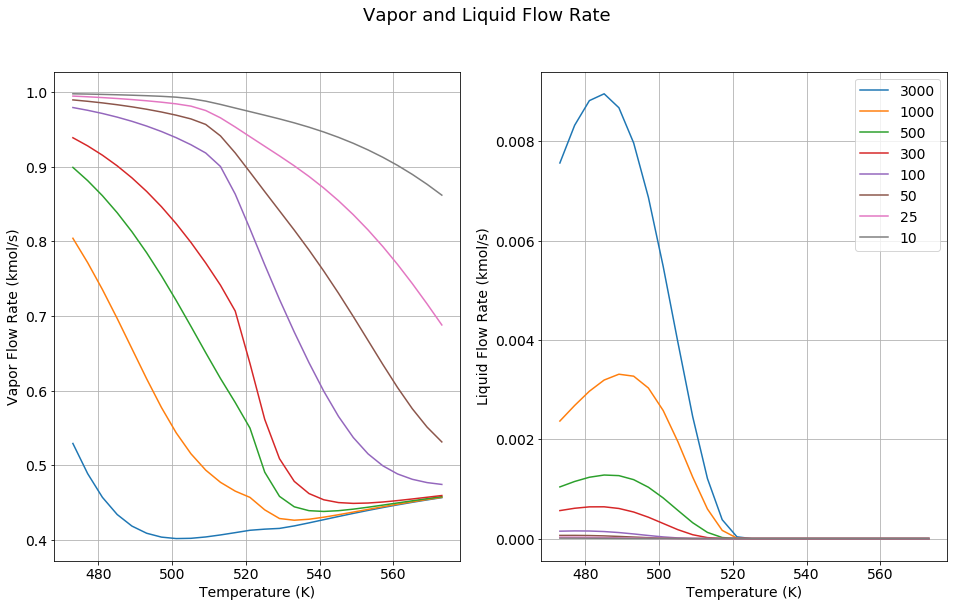

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['V'])
ax1.set_ylabel('Vapor Flow Rate (kmol/s)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.grid()

for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['L'])
ax2.set_ylabel('Liquid Flow Rate (kmol/s)',fontsize=14)
ax2.set_xlabel('Temperature (K)',fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid()

ax2.legend(catrange,fontsize=14)
fig.suptitle('Vapor and Liquid Flow Rate',fontsize=18)

plt.show()

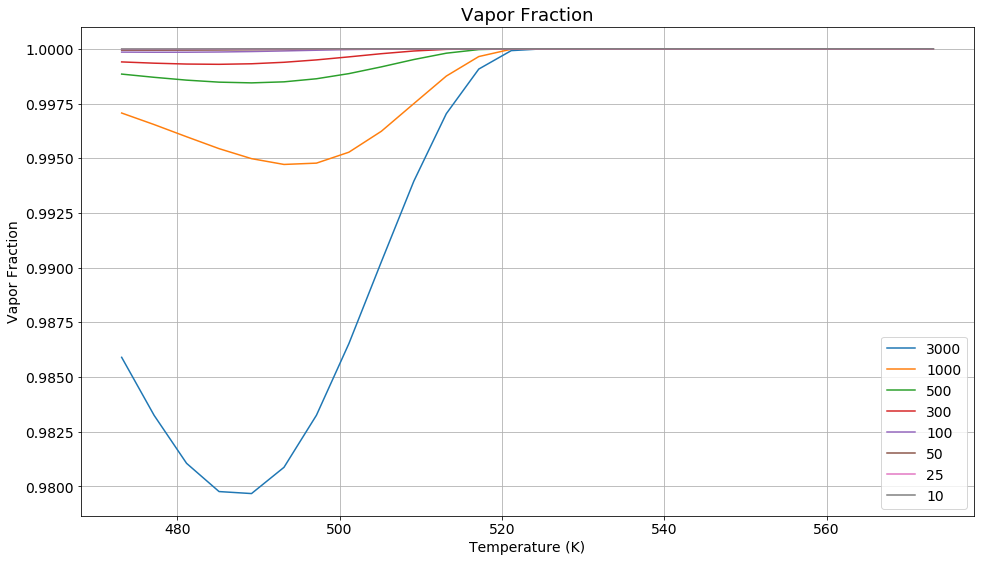

In [30]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.divide(rf_data_master[c]['V'],np.add(rf_data_master[c]['V'],rf_data_master[c]['L'])))
ax1.set_ylabel('Vapor Fraction',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title('Vapor Fraction',fontsize=18)
ax1.grid()
plt.show()

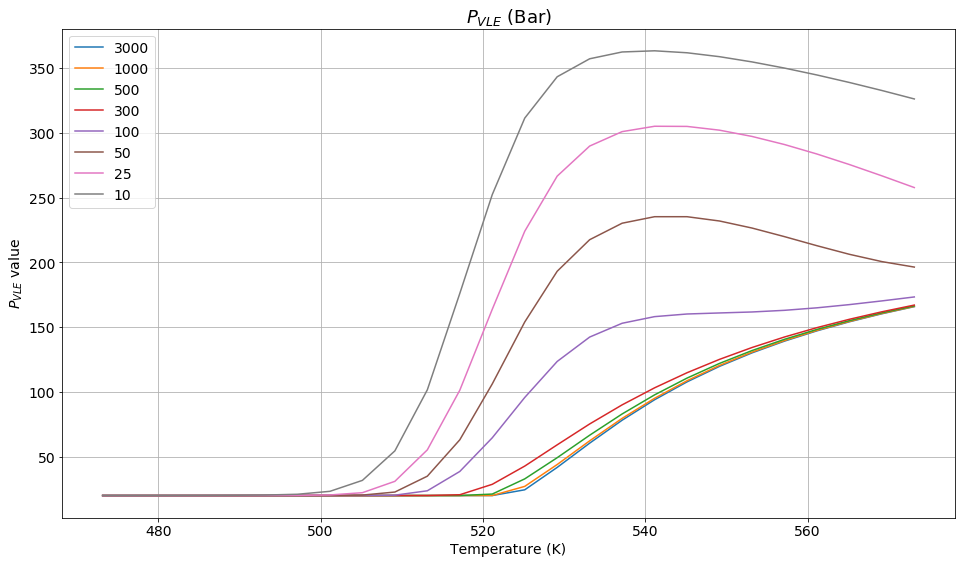

In [31]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['P_VLE'])
ax1.set_ylabel(r'$P_{VLE}$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title(r'$P_{VLE}$ (Bar)',fontsize=18)
ax1.grid()
plt.show()

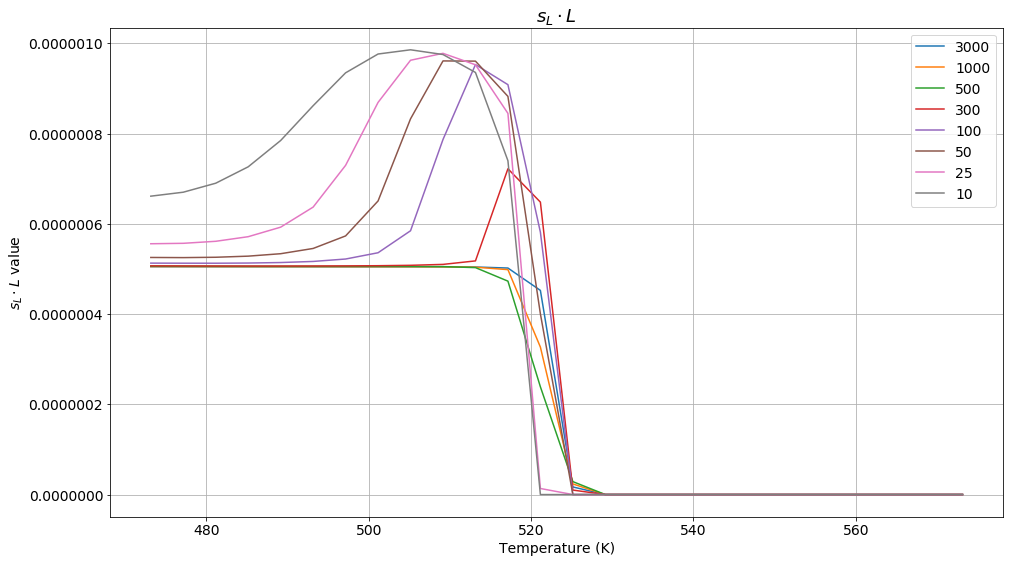

In [32]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.multiply(rf_data_master[c]['s_L'],rf_data_master[c]['L']))
ax1.set_ylabel(r'$s_L \cdot L$ value',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
# ax1.set_ylim(2.49e-5,2.51e-5)
ax1.set_title(r'$s_L \cdot L$',fontsize=18)
ax1.grid()
plt.show()